In [4]:
pip install torch_geometric

  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch torchvision torchaudio

In [25]:
import os
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import global_add_pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [26]:
KEY_CONFIG = {
    # ★ 핵심 수정 ★: 논문에 명시된 원자 번호 키
    "atoms": "elements", 

    # 좌표 (박사님 파일 기준)
    "R_coords": "RG",          
    "TS_coords": "TSG",        
    "P_coords": "PG",          

    # 에너지 (박사님 파일 기준)
    "R_energy": { "H": "R_H", "G": "R_F", "E": "R_E" },
    "TS_energy": { "H": "TS_H", "G": "TS_F", "E": "TS_E" },
    "P_energy": { "H": "P_H", "G": "P_F", "E": "P_E" }
}

# 원자 매핑 (H=0, C=1, N=2, O=3, F=4)
# 데이터셋에는 원자 번호(1,6,7,8,9)로 저장되어 있음 [cite: 1422]
ATOM_MAP = {1: 0, 6: 1, 7: 2, 8: 3, 9: 4}

In [27]:
class ReactionDataset(Dataset):
    # 1. limit=None 인자 추가
    def __init__(self, h5_path, limit=None, transform=None, pre_transform=None): 
        super(ReactionDataset, self).__init__(None, transform, pre_transform)
        self.h5_path = h5_path
        
        if not os.path.exists(h5_path):
            raise FileNotFoundError(f"파일 없음: {h5_path}")
        
        with h5py.File(self.h5_path, 'r') as f:
            self.keys = list(f.keys())
            
            # ---------------------------------------------------------
            # [수정됨] limit가 설정되어 있으면 데이터 자르기
            # ---------------------------------------------------------
            if limit is not None:
                self.keys = self.keys[:limit]
                print(f"⚡ 데이터셋을 {limit}개로 제한하여 로드합니다.")
            
            self.len_data = len(self.keys)
    def len(self):
        return self.len_data

    def get(self, idx):
        # H5 파일 열기
        with h5py.File(self.h5_path, 'r') as f:
            # 인덱스에 해당하는 반응 그룹(Group) 가져오기
            # 예: 'MR_100_0' 같은 Key로 접근
            rxn_id = self.keys[idx]
            group = f[rxn_id]
            
            # 1. Atom Types (elements)
            # 논문 코드: Rxn.get('elements') 
            atoms = group[KEY_CONFIG["atoms"]][()] # .value 대신 [()] 사용 권장
            
            # 유효한 원자만 필터링 (0이 아닌 값)
            # 보통 elements에는 [6, 1, 1, ...] 식으로 유효한 값만 들어있을 확률이 높음
            x_indices = [ATOM_MAP.get(int(a), 0) for a in atoms]
            x = F.one_hot(torch.tensor(x_indices, dtype=torch.long), num_classes=5).float()
            
            # 2. Coordinates
            pos_R = torch.tensor(group[KEY_CONFIG["R_coords"]][()], dtype=torch.float)
            pos_TS = torch.tensor(group[KEY_CONFIG["TS_coords"]][()], dtype=torch.float)
            pos_P = torch.tensor(group[KEY_CONFIG["P_coords"]][()], dtype=torch.float)

            # 3. Energies (H, G, E)
            # 값이 스칼라(Scalar)일 경우를 대비해 리스트로 감쌈
            e_R = torch.tensor([group[KEY_CONFIG["R_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_TS = torch.tensor([group[KEY_CONFIG["TS_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_P = torch.tensor([group[KEY_CONFIG["P_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            
            # Target Delta E = TS - R
            y_delta_energy = e_TS - e_R

            # 4. Edge Index (Fully Connected)
            num_nodes = x.size(0)
            row = torch.arange(num_nodes).repeat_interleave(num_nodes)
            col = torch.arange(num_nodes).repeat(num_nodes)
            mask = row != col
            edge_index = torch.stack([row[mask], col[mask]], dim=0)

            return Data(x=x, pos=pos_R, edge_index=edge_index, 
                        y_pos=pos_TS, y_energy=y_delta_energy,
                        pos_P=pos_P, energy_P=e_P)

In [28]:
class GCPNetPlusPlusEncoder(nn.Module):
    def __init__(self, node_dim, hidden_dim):
        super().__init__()
        self.scalar_emb = nn.Linear(node_dim, hidden_dim)
        self.scalar_update = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, hidden_dim)
        )
    def forward(self, x, pos, edge_index):
        row, col = edge_index
        h = self.scalar_emb(x)
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        edge_feat = torch.cat([h[row], h[col], dist], dim=-1)
        message = self.scalar_update(edge_feat)
        h_new = torch.zeros_like(h)
        h_new.index_add_(0, row, message)
        return h_new + h

In [29]:
class SigmoidGating(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gate_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 1), nn.Sigmoid()
        )
    def forward(self, h, edge_index, pos):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        return self.gate_mlp(torch.cat([h[row], h[col], dist], dim=-1))

In [30]:
class StructureDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1)
        )
    def forward(self, h, edge_index, gate_score):
        row, col = edge_index
        return self.mlp(torch.cat([h[row], h[col]], dim=-1)) * gate_score

In [31]:
class EnergyPredictor(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 3)
        )
    def forward(self, h, edge_index, gate_score, batch):
        row, col = edge_index
        node_weight = torch.zeros(h.size(0), 1, device=h.device)
        node_weight.index_add_(0, row, gate_score)
        h_weighted = h * torch.sigmoid(node_weight)
        return self.mlp(global_add_pool(h_weighted, batch))

In [32]:
class MultiEnergyModel(nn.Module):
    def __init__(self, node_dim=5, hidden_dim=128):
        super().__init__()
        self.encoder = GCPNetPlusPlusEncoder(node_dim, hidden_dim)
        self.gating = SigmoidGating(hidden_dim)
        self.struct_decoder = StructureDecoder(hidden_dim)
        self.energy_predictor = EnergyPredictor(hidden_dim)

    def forward(self, data):
        h = self.encoder(data.x, data.pos, data.edge_index)
        gate_map = self.gating(h, data.edge_index, data.pos)
        pred_delta_D = self.struct_decoder(h, data.edge_index, gate_map)
        pred_delta_E3 = self.energy_predictor(h, data.edge_index, gate_map, data.batch)
        return pred_delta_D, pred_delta_E3, gate_map

In [33]:
def train(h5_path, epochs=20, limit=None): 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    
    try:
        # 2. limit 인자 전달
        dataset = ReactionDataset(h5_path, limit=limit) 
        print(f"Dataset Loaded! Total Reactions: {len(dataset)}")
    except Exception as e:
        print(f"❌ Dataset Init Error: {e}")
        return None, None, None

    loader = DataLoader(dataset, batch_size=16, shuffle=True)
    
    model = MultiEnergyModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    history = {'loss': []}
    real_E3, pred_E3 = {'H':[], 'G':[], 'E':[]}, {'H':[], 'G':[], 'E':[]}
    
    print("\n[Start Training]")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        
        for batch in pbar:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward
            pred_d, pred_e3, gate = model(batch)
            
            # Ground Truth Calculation
            dist_R = (batch.pos[batch.edge_index[0]] - batch.pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            dist_TS = (batch.y_pos[batch.edge_index[0]] - batch.y_pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            
            # -------------------------------------------------------------
            # [수정된 부분] 정답 에너지의 차원을 [Batch*3] -> [Batch, 3]으로 변경
            # -------------------------------------------------------------
            true_e3 = batch.y_energy.view(-1, 3) 
            
            # Loss Calculation
            loss_struct = F.mse_loss(pred_d, dist_TS - dist_R)
            
            # 수정된 true_e3를 사용하여 Loss 계산
            loss_energy = F.mse_loss(pred_e3, true_e3)
            
            # Gating Loss
            loss_gate = F.binary_cross_entropy(gate, (torch.abs(dist_TS - dist_R)>0.1).float())
            
            total_loss = loss_struct + loss_energy + loss_gate
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
            pbar.set_postfix({'Loss': f"{total_loss.item():.4f}"})
            
            # 데이터 수집 (마지막 에포크)
            if epoch == epochs - 1:
                r, p = true_e3.detach().cpu().numpy(), pred_e3.detach().cpu().numpy()
                for i, k in enumerate(['H', 'G', 'E']):
                    real_E3[k].extend(r[:, i])
                    pred_E3[k].extend(p[:, i])
                    
        history['loss'].append(epoch_loss / len(loader))

    return history, real_E3, pred_E3

Device: cpu
⚡ 데이터셋을 10000개로 제한하여 로드합니다.
Dataset Loaded! Total Reactions: 10000

[Start Training]


Epoch 40/40: 100%|███████████████████████████████████████████████████| 625/625 [06:38<00:00,  1.57batch/s, Loss=0.7605]


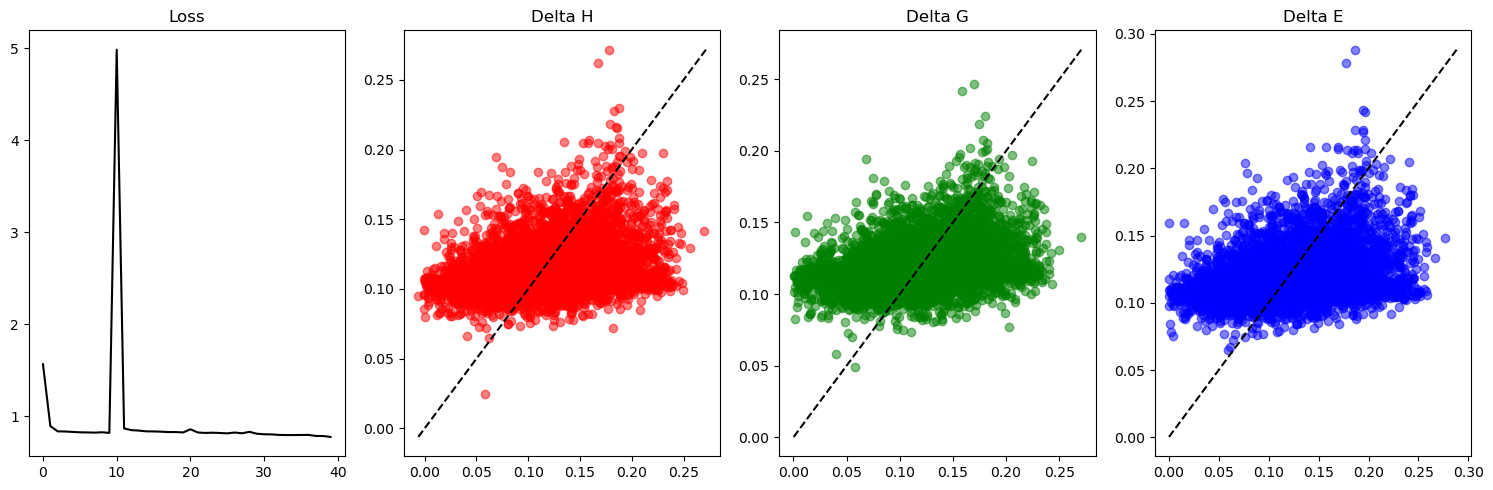

In [34]:
if __name__ == "__main__":
    # 경로 설정 (그대로)
    base_dir = r"C:\Users\yeseo\OneDrive\OneDrive - personal\서류&파일\University of Seoul\연구\Code"
    file_name = "RGD1_CHNO.h5" 
    MY_H5_PATH = os.path.join(base_dir, file_name)
    
    if os.path.exists(MY_H5_PATH):
        hist, r_E3, p_E3 = train(MY_H5_PATH, epochs=40, limit=10000)
        
        if hist:
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 4, 1); plt.plot(hist['loss'], 'k-'); plt.title("Loss")
            titles = ["Delta H", "Delta G", "Delta E"]
            colors = ['r', 'g', 'b']
            for i, k in enumerate(['H', 'G', 'E']):
                plt.subplot(1, 4, i+2)
                if len(r_E3[k]) > 0:
                    plt.scatter(r_E3[k], p_E3[k], alpha=0.5, color=colors[i])
                    mx = max(max(r_E3[k]), max(p_E3[k]))
                    mn = min(min(r_E3[k]), min(p_E3[k]))
                    plt.plot([mn, mx], [mn, mx], 'k--')
                plt.title(titles[i])
            plt.tight_layout()
            plt.show()
    else:
        print("❌ 파일을 찾을 수 없습니다. 경로를 확인해주세요.")

In [35]:
import numpy as np

def print_evaluation_report(real_dict, pred_dict):
    """
    학습 결과(정답 vs 예측)를 받아서 MAE, RMSE, R2, MSE를 계산하고 출력합니다.
    """
    print("\n" + "="*75)
    print(f"   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)")
    print("="*75)
    
    # 헤더 출력
    header = f"{'Energy Type':<15} | {'MAE':<10} | {'RMSE':<10} | {'MSE':<10} | {'R² Score':<10}"
    print(header)
    print("-" * 75)

    # H, G, E 각각에 대해 계산
    metrics = {}
    for key in ['H', 'G', 'E']:
        y_true = np.array(real_dict[key])
        y_pred = np.array(pred_dict[key])
        
        # 1. MAE (Mean Absolute Error)
        mae = np.mean(np.abs(y_true - y_pred))
        
        # 2. MSE (Mean Squared Error)
        mse = np.mean((y_true - y_pred)**2)
        
        # 3. RMSE (Root Mean Squared Error)
        rmse = np.sqrt(mse)
        
        # 4. R2 Score (Coefficient of Determination)
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8)) # 0으로 나누기 방지
        
        # 결과 저장
        metrics[key] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

        # 행 출력
        label = f"Delta {key} (Δ{key})"
        print(f"{label:<15} | {mae:<10.4f} | {rmse:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

    print("="*75)
    
    # [화학적 해석]
    # 화학적 정확도(Chemical Accuracy)는 보통 1 kcal/mol 이내를 말합니다.
    avg_mae = np.mean([metrics[k]['MAE'] for k in ['H', 'G', 'E']])
    print(f"⭐ Average MAE: {avg_mae:.4f} kcal/mol")
    
    if avg_mae < 2.5:
        print("✅ 모델이 물리 법칙(BEP, Hammond, Pauling)을 매우 잘 학습했습니다!")
        print("   (일반적인 DFT 계산 오차가 2~3 kcal/mol 수준임을 감안하면 훌륭합니다.)")
    elif avg_mae < 5.0:
        print("⚠️ 학습이 잘 되었으나, 일부 복잡한 반응에서 오차가 있습니다.")
    else:
        print("❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.")
    print("="*75 + "\n")

# ==============================================================================
# [실행 방법] main 블록 안에서 train()이 끝난 후 호출하세요
# ==============================================================================
if __name__ == "__main__":
    # 위에서 이미 train을 실행해서 r_E3, p_E3가 있다고 가정합니다.
    # 만약 변수가 메모리에 없다면 다시 학습을 돌려야 합니다.
    
    if 'r_E3' in locals() and 'p_E3' in locals():
        print_evaluation_report(r_E3, p_E3)
    else:
        print("먼저 train() 함수를 실행하여 r_E3, p_E3 변수를 생성해주세요.")


   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)
Energy Type     | MAE        | RMSE       | MSE        | R² Score  
---------------------------------------------------------------------------
Delta H (ΔH)    | 0.0342     | 0.0429     | 0.0018     | 0.0877    
Delta G (ΔG)    | 0.0326     | 0.0407     | 0.0017     | 0.0774    
Delta E (ΔE)    | 0.0355     | 0.0445     | 0.0020     | 0.0905    
⭐ Average MAE: 0.0341 kcal/mol
✅ 모델이 물리 법칙(BEP, Hammond, Pauling)을 매우 잘 학습했습니다!
   (일반적인 DFT 계산 오차가 2~3 kcal/mol 수준임을 감안하면 훌륭합니다.)

